# Post processing approaches

### Import statements

In [1120]:
%load_ext autoreload
%autoreload 2

# 3rd party imports
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
np.set_printoptions(linewidth=1000)
from scipy.sparse.linalg import lgmres
import sympy as sp
import pandas as pd

import scipy.optimize as opt
from scipy.ndimage import sobel
from scipy.optimize import minimize


# Local imports
import modules.laplacian as laplacian
import modules.jacobian as jacobian
import modules.correspondences as correspondences

import random
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1121]:
# global stuff

init_GD = []
final_GD = []
dev_GD = []

init_OP = []
final_OP = []
dev_OP = []

### Test with mock points

In [1122]:
# experiment with mock points

# Create some example correspondence points
msample = np.array([
    [0, 1, 0],
    [0, 2, 3],
])
fsample = np.array([
    [0, 1, 3],
    [0, 2, 0],
])

fixed_sample = np.zeros((1, 5, 5)) # depth, rows, cols

deformation_i, A, Zd, Yd, Xd = laplacian.sliceToSlice3DLaplacian(fixed_sample, msample, fsample)

dx = lgmres(A, Xd, tol = 1e-2)[0]
print("dx shape:", dx.shape)
print("dx:", dx)
print(f'deformation_i.shape: {deformation_i.shape}')

# Show values
np.set_printoptions(linewidth=1000)
print("A shape:", A.shape)
#print(A.toarray())
print("Rank of A:", np.linalg.matrix_rank(A.toarray()))
print("Yd shape:", Yd.shape)
print(Yd)
print("Xd shape:", Xd.shape)
print(Xd)
print("Zd shape:", Zd.shape)
print(Zd)


Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
dx shape: (25,)
dx: [ 1.92045841  2.19371007  2.99974044  0.09595895 -2.99974044  1.65265726  1.65555701  1.48884074  0.27782782 -0.92292217  1.38276003  1.29155864  1.02934627  0.45552205 -0.04563881  1.20243271  1.10130517  0.88692761  0.5778933   0.34180955  1.119485    1.02732735  0.85251929  0.6445325   0.49838286]
deformation_i.shape: (3, 1, 5, 5)
A shape: (25, 25)
Rank of A: 25
Yd shape: (25,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Xd shape: (25,)
[ 0.  0.  3.  0. -3.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Zd shape: (25,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


/var/folders/pj/ny1dgkl90cj0mpph_t0mvd000000gn/T/ipykernel_61428/801346265.py:17: DeprecationWarning: scipy.sparse.linalg.lgmres called without specifying `atol`. The default value will change in the future. To preserve current behavior, set ``atol=tol``.
  dx = lgmres(A, Xd, tol = 1e-2)[0]


## Gradient descent approach

### Methods

In [1123]:
def compute_jacobian2D(phix, phiy):
    ''' 
    phix, phiy: (5,5)
    '''
    """Computes the Jacobian determinant J(x) for a 2D deformation field."""
    dphix_dx = np.gradient(phix, axis=1)
    dphiy_dx = np.gradient(phiy, axis=1)
    dphix_dy = np.gradient(phix, axis=0)
    dphiy_dy = np.gradient(phiy, axis=0)

    dphix_dx = dphix_dx.astype(np.float64)
    dphiy_dx = dphiy_dx.astype(np.float64)
    dphix_dy = dphix_dy.astype(np.float64)
    dphiy_dy = dphiy_dy.astype(np.float64)

    J = (1+dphix_dx)*(1+dphiy_dy) - dphix_dy*dphiy_dx # Jacobian determinant formula
    return J, dphix_dx, dphix_dy, dphiy_dx, dphiy_dy


def jacobian_det1(deformation_i):
    '''
    expects shape (2,5,5)
    '''
    phix = deformation_i[1,:,:]
    phiy = deformation_i[0,:,:]
    return compute_jacobian2D(phix, phiy)

def jacobian_det2(phi_xy, shape):
    phix = phi_xy[:len(phi_xy) // 2].reshape(shape[-2:])
    phiy = phi_xy[len(phi_xy) // 2:].reshape(shape[-2:])
    return compute_jacobian2D(phix, phiy)[0]


In [1124]:
def gradient_descent_2D(phi_prime, A, Xd, Yd, max_iters=1000, step_size=0.1):
    '''
    expects shape (2,5,5)
    Iteratively enforces J(phi) > 0 by modifying phi using Kuhn-Tucker conditions.
    '''

    
    # cannot replace by ones as gradient descent will just stop
    phi = phi_prime.copy()
    
    for _ in range(max_iters):
        J, dphix_dx, dphix_dy, dphiy_dx, dphiy_dy = jacobian_det1(phi)
        violations = J <= 0  # Identify grid points where constraint is violated
        #print(f'violations are at {J[violations]}')
        
        if not np.any(violations):
            break  # Stop if all Jacobians are positive
        
        # Compute the update using the gradient of J
        #dphix_dx, dphix_dy, dphiy_dx, dphiy_dy = gradients

        #grad_J_phix = dphiy_dy - dphiy_dx 
        #grad_J_phiy = dphix_dx - dphix_dy

        grad_J_phix = (1+dphiy_dy)*np.gradient(dphix_dx, axis=1) - dphiy_dx*np.gradient(dphix_dy, axis=0)
        grad_J_phiy = (1+dphix_dx)*np.gradient(dphiy_dy, axis=0) - dphix_dy*np.gradient(dphiy_dx, axis=1)

        #grad_J_phix = (1+dphiy_dy)*(np.gradient(dphix_dx, axis=1)/dphix_dx) - dphiy_dx*(np.gradient(dphix_dy, axis=0)/dphix_dy)
        #grad_J_phiy = (1+dphix_dx)*(np.gradient(dphiy_dy, axis=0)/dphiy_dy) - dphix_dy*(np.gradient(dphiy_dx, axis=1)/dphiy_dx)
        
        # Apply Kuhn-Tucker update rule only at violating points
        lambda_vals = np.zeros_like(J)
        lambda_vals[violations] = step_size  # Adjust step size adaptively if needed
        
        phi[1, :, :] -= (lambda_vals / 2) * grad_J_phix  # Update phix
        phi[0, :, :] -= (lambda_vals / 2) * grad_J_phiy  # Update phiy

    dxi = phi_prime[1, :, :].flatten()
    dyi = phi_prime[0, :, :].flatten()
    dxf = phi[1, :, :].flatten()
    dyf = phi[0, :, :].flatten()

    init_error = np.sqrt(np.sum((A @ dxi - Xd)**2) + np.sum((A @ dyi - Yd)**2))
    fin_error = np.sqrt(np.sum((A @ dxf - Xd)**2) + np.sum((A @ dyf - Yd)**2))
    deviation = np.sqrt(np.sum((dxi-dxf)**2) + np.sum((dyi-dyf)**2))
    
    init_GD.append(init_error)
    final_GD.append(fin_error)
    dev_GD.append(deviation)

    print(f'GD initial error: {init_error}')
    print(f'GD result error: {fin_error}')
    print(f'GD deviation from original: {deviation}')
    
    return phi

## SciPy optimise approach

### Full SLSQP

In [1125]:
def idx_adjacency(shape):
    idx_adj = {}
    for z in range(shape[0]):
        for y in range(shape[1]):
            for x in range(shape[2]):
                l_idx = laplacian.get_laplacian_index(z, y, x, shape)
                adjacent_indices = laplacian.get_adjacent_indices(z, y, x, shape)
                idx_adj[l_idx] = adjacent_indices
    return idx_adj

# Define the objective function
def objective(phi, A_, b_):
    return np.linalg.norm(A_ @ phi - b_)**2

# Define the constraints
def jdet_constraint(phi, idx, idx_adj, y_offset, epsilon=1e-6):
    left_idx, right_idx, up_idx, down_idx = idx_adj[idx]
    
    if left_idx is None:  # Left edge
        dxx = (phi[right_idx] - phi[idx]) / 2
        dyx = (phi[right_idx + y_offset] - phi[idx + y_offset]) / 2
    elif right_idx is None:  # Right edge
        dxx = (phi[idx] - phi[left_idx]) / 2
        dyx = (phi[idx + y_offset] - phi[left_idx + y_offset]) / 2
    else: 
        dxx = (phi[right_idx] - phi[left_idx]) / 2
        dyx = (phi[right_idx + y_offset] - phi[left_idx + y_offset]) / 2
    
    if up_idx is None:  # Top edge
        dyy = (phi[down_idx + y_offset] - phi[idx + y_offset]) / 2
        dxy = (phi[down_idx] - phi[idx]) / 2
    elif down_idx is None:  # Bottom edge
        dyy = (phi[idx + y_offset] - phi[up_idx + y_offset]) / 2
        dxy = (phi[idx] - phi[up_idx]) / 2
    else:
        dyy = (phi[down_idx + y_offset] - phi[up_idx + y_offset]) / 2
        dxy = (phi[down_idx] - phi[up_idx]) / 2
        
    return ((dxx + 1) * (dyy + 1)) - (dxy * dyx) - epsilon

def scipy_minimize(A, Xd, Yd, fixed_sample, methodName='SLSQP'):
    
    # Define the matrix A and vector B

    # A_ is [[L,0], [0,L]]
    # b_ is [[x],[y]]
    A0 = np.zeros((A.shape[0], A.shape[1]))

    # Creating the big combined Laplacian matrix
    A_ = np.block([
        [A.todense(), A0],
        [A0, A.todense()]
    ])
    b_ = np.concatenate([Xd, Yd])
    phi_xy = lgmres(A_, b_, tol = 1e-2)[0]
    phi = phi_xy

    y_offset = len(b_) // 2
    idx_adj = idx_adjacency(fixed_sample.shape)

    # Create the constraints
    constraints = []
    y_offset = len(b_) // 2
    idx_adj = idx_adjacency(fixed_sample.shape)
    for i in range(len(b_) // 2):
        constraints += [{'type': 'ineq', 'fun': lambda phi, i=i: jdet_constraint(phi, i, idx_adj, y_offset)}]

    # Initial guess
    phi0 = phi_xy

    # Solve the optimization problem
    print(f'Reached the optimisation line. Number of constraints = {len(constraints)}')
    start = time.time()

    result = minimize(lambda phi: objective(phi, A_, b_), phi0, constraints=constraints, options={'maxiter': 1000, 'disp': True}, method=methodName)

    end = time.time()
    print(f'Optimisation completed! Time taken = {end-start}s')
    
    init_error = objective(phi0, A_, b_)
    fin_error = result.fun
    deviation = np.sqrt(np.sum((phi0 - result.x)**2))
    
    init_OP.append(init_error)
    final_OP.append(fin_error)
    dev_OP.append(deviation)

    # Display the solutions
    if result.success:
        print(f'OP phi0 error: {init_error}')
        print(f'OP result error: {fin_error}')
        print(f'OP deviation from initial: {deviation}')
    else:
        print("Optimization failed:", result.message)
    
    phi = np.zeros((2, *fixed_sample.shape[1:]))
    phi[1] = result.x[:len(result.x) // 2].reshape(fixed_sample.shape[-2:])
    phi[0] = result.x[len(result.x) // 2:].reshape(fixed_sample.shape[-2:])

    return phi


### Reduce constraints

In [1126]:
def reduced_scipy_minimize(A, Xd, Yd, fixed_sample, methodName='SLSQP'):
    
    # Define the matrix A and vector B

    # A_ is [[L,0], [0,L]]
    # b_ is [[x],[y]]
    A0 = np.zeros((A.shape[0], A.shape[1]))

    # Creating the big combined Laplacian matrix
    A_ = np.block([
        [A.todense(), A0],
        [A0, A.todense()]
    ])
    b_ = np.concatenate([Xd, Yd])
    phi_xy = lgmres(A_, b_, tol = 1e-2)[0]

    # Create the constraints
    constraints = []
    y_offset = len(b_) // 2
    idx_adj = idx_adjacency(fixed_sample.shape)

    random_sample = random.sample(range(len(b_)//2), 5)

    for i in random_sample:
        constraints += [{'type': 'ineq', 'fun': lambda phi, i=i: jdet_constraint(phi, i, idx_adj, y_offset)}]

    # Initial guess
    phi0 = phi_xy

    # Solve the optimization problem
    print(f'Running reduced scipy with lesser constraints : {len(constraints)}')
    start = time.time()

    result = minimize(lambda phi: objective(phi, A_, b_), phi0, constraints=constraints, options={'maxiter': 1000, 'disp': True}, method=methodName)

    end = time.time()
    print(f'Optimisation completed! Time taken = {end-start}s')
    
    init_error = objective(phi0, A_, b_)
    fin_error = result.fun
    deviation = np.sqrt(np.sum((phi0 - result.x)**2))
    
    init_OP.append(init_error)
    final_OP.append(fin_error)
    dev_OP.append(deviation)

    # Display the solutions
    if result.success:
        print(f'OP phi0 error: {init_error}')
        print(f'OP result error: {fin_error}')
        print(f'OP deviation from initial: {deviation}')
    else:
        print("Optimization failed:", result.message)
    
    phi = np.zeros((2, *fixed_sample.shape[1:]))
    phi[1] = result.x[:len(result.x) // 2].reshape(fixed_sample.shape[-2:])
    phi[0] = result.x[len(result.x) // 2:].reshape(fixed_sample.shape[-2:])

    return phi

In [1127]:
def nearest_center(shape, n):
    near_cent = {}
    for z in range(shape[0]):
        for y in range(shape[1]):
            for x in range(shape[2]):
                l_idx = laplacian.get_laplacian_index(z, y, x, shape)
                z_cent = z
                y_cent = y
                x_cent = x
                if (x-n < 0):
                    x_cent = n
                elif (shape[2]-x < n+1):
                    x_cent = shape[2]-n-1

                if (y-n < 0):
                    y_cent = n
                elif (shape[1]-y < n):
                    y_cent = shape[1]-n-1
                center_indices = [z, y_cent, x_cent]
                near_cent[l_idx] = center_indices
                # print("Nearest center values for index ", l_idx, center_indices)
    return near_cent

def original_coordinates(shape):
    ori_coord = {}
    for z in range(shape[0]):
        for y in range(shape[1]):
            for x in range(shape[2]):
                ori_coord[z * shape[1] * shape[2] + y * shape[2] + x] = (z,y,x)
    return ori_coord

# Define the objective function
def objective2(phi, phi_init, A_, b_):
    return np.linalg.norm(phi - phi_init)**2 + np.linalg.norm(A_ @ phi - b_)**2

def get_phi_sub(phi, cz, cy, cx, shape):
    phix = phi[:len(phi)//2].reshape(shape[-2:])
    phiy = phi[len(phi)//2: ].reshape(shape[-2:])
    phix = phix[cy-2:cy+3, cx-2:cx+3]
    phiy = phiy[cy-2:cy+3, cx-2:cx+3]
    return np.concatenate([phix.flatten(), phiy.flatten()])

def iterative_scipy_minimize(phi_xy, A_, b_, fixed_sample, fsample, msample, methodName='SLSQP'):
    threshold = 0.05
    # monitor total and individual times
    indi_times = []
    tot_start = time.time()
    
    # initialise the phi to be returned
    phi = np.zeros((2, *fixed_sample.shape[1:]))
    phi[1] = phi_xy[:len(phi_xy) // 2].reshape(fixed_sample.shape[-2:])
    phi[0] = phi_xy[len(phi_xy) // 2:].reshape(fixed_sample.shape[-2:])


    # collect indices with -ve Jacobians into a list in a sorted fashion
    J_init = jacobian_det2(phi_xy, fixed_sample.shape).flatten()
    neg_jacobian_indices = np.where(J_init <= threshold)[0]
    neg_jacobian_indices = neg_jacobian_indices[np.argsort(J_init[neg_jacobian_indices])]
    
    print(f'Negative Jacobians found at {neg_jacobian_indices}')

    # find the nearest center of a 5x5 matrix around each pixel
    near_cent = nearest_center(fixed_sample.shape, 2)
    ori_coord = original_coordinates(fixed_sample.shape)

    sub_shape = (1,5,5)
    sub_idx_adj = idx_adjacency(sub_shape)

    # perform optimisation for each index with negative Jacobian
    for neg_index in neg_jacobian_indices:
        # if the negative values has already been fixed, skip it
        if (jacobian_det2(np.concatenate([phi[1].flatten(), phi[0].flatten()]), fixed_sample.shape).flatten()[neg_index] > 0):
            continue
        
        z,y,x = ori_coord[neg_index]
        cz, cy, cx = near_cent[neg_index]

        print(f'Analysing index {neg_index}: Original coord: {x,y,z}, nearest: {cx, cy, cz}')
        
        # solve linear equations 
        lin_start = time.time()
        phi0_sub, A_sub, b_sub = laplacian.compute3DLaplacianFromShape(sub_shape, np.empty((0,3)), np.empty((0,3))) 
        # print("ALL SHAPES", phi0_sub.shape, A_sub.shape, b_sub.shape)
        lin_end = time.time()
        print(f'Lapl eqns for index {neg_index} solved in {lin_end-lin_start}s')

        # get constraints for optimisation
        constraints = []
        y_offset_sub = len(b_sub)//2
        for i_sub in range(len(b_sub)//2):
            constraints += [{'type': 'ineq', 'fun': lambda phi, i=i_sub: jdet_constraint(phi, i, sub_idx_adj, y_offset_sub, threshold)}]

        op_start = time.time()
        # in objective, should i use phi0_sub or the very initial phi_xy to penalise?
        phi_init_sub = get_phi_sub(phi_xy, cz, cy, cx, fixed_sample.shape)
        result = minimize(lambda phi: objective2(phi, phi_init_sub, A_sub, b_sub), phi0_sub, constraints=constraints, options={'maxiter': 1000, 'disp': True}, method=methodName)
        op_end = time.time()

        print(f'Optimisation for index {neg_index} completed in {op_end-op_start}s')
        indi_times.append(op_end-op_start)
        if result.success:
            print(f'OP result error for index {neg_index}: {result.fun}')
        else:
            print("Optimisation failed: ", result.message)

        # substitute values from computed deformation into original phi
        # b_ was XYd, so phi_x is the first half
        phi_x_sub = result.x[:len(result.x) // 2].reshape(sub_shape[-2:])
        phi_y_sub = result.x[len(result.x) // 2:].reshape(sub_shape[-2:])

        print("RESULT SHAPES", phi[1].shape, phi[1][cx-2:cx+3, cy-2:cy+3].shape, cx-2, cx+3, cy-2, cy+3, cy)

        phi[1][cy-2:cy+3, cx-2:cx+3] = phi_x_sub
        phi[0][cy-2:cy+3, cx-2:cx+3] = phi_y_sub

    phi_temp = np.concatenate([phi[1].flatten(), phi[0].flatten()])
    init_error = objective2(phi_xy, phi_xy, A_, b_)
    fin_error = objective2(phi_temp, phi_xy, A_, b_)
    deviation = np.sqrt(np.sum((phi_xy - phi_temp)**2))

    tot_end = time.time()
    print(f'Total time taken for iterative SLSQP : {tot_end - tot_start} split as {indi_times}')
    
    
    return phi

## Miscellanous

#### Jacobian comparisons

In [1128]:
# compare sitk Jacobian vs my Jacobian

j1 = jacobian.sitk_jacobian_determinant(deformation_i)
j2 = jacobian_det1(deformation_i[1:,0])[0]
print(j1.shape, j2.shape)
print(j1)
print(j2)

SITK deformation shape: (1, 5, 5, 3)
(1, 5, 5) (5, 5)
[[[ 1.13662583  1.53964101 -0.04887556 -1.99974044 -0.54784969]
  [ 1.00144987  0.91809174  0.31113541 -0.20588146  0.399625  ]
  [ 0.95439931  0.82329312  0.5819817   0.46250746  0.74941957]
  [ 0.94943623  0.84224745  0.73829406  0.72744097  0.88195813]
  [ 0.95392117  0.86651714  0.80860258  0.82293178  0.92692518]]]
[[ 1.27325166  1.53964101 -0.04887556 -1.99974044 -2.09569939]
 [ 1.00289975  0.91809174  0.31113541 -0.20588146 -0.20075   ]
 [ 0.90879861  0.82329312  0.5819817   0.46250746  0.49883914]
 [ 0.89887246  0.84224745  0.73829406  0.72744097  0.76391626]
 [ 0.90784235  0.86651714  0.80860258  0.82293178  0.85385036]]


In [1129]:
# reason for Nan is that phiy is mostly zero!
jacobian_det1(deformation_i[1:,0])

(array([[ 1.27325166,  1.53964101, -0.04887556, -1.99974044, -2.09569939],
        [ 1.00289975,  0.91809174,  0.31113541, -0.20588146, -0.20075   ],
        [ 0.90879861,  0.82329312,  0.5819817 ,  0.46250746,  0.49883914],
        [ 0.89887246,  0.84224745,  0.73829406,  0.72744097,  0.76391626],
        [ 0.90784235,  0.86651714,  0.80860258,  0.82293178,  0.85385036]]),
 array([[ 2.73251662e-01,  5.39641013e-01, -1.04887556e+00, -2.99974044e+00, -3.09569939e+00],
        [ 2.89974922e-03, -8.19082609e-02, -6.88864594e-01, -1.20588146e+00, -1.20075000e+00],
        [-9.12013890e-02, -1.76706881e-01, -4.18018298e-01, -5.37492541e-01, -5.01160858e-01],
        [-1.01127541e-01, -1.57752553e-01, -2.61705939e-01, -2.72559028e-01, -2.36083742e-01],
        [-9.21576545e-02, -1.33482856e-01, -1.91397425e-01, -1.77068218e-01, -1.46149643e-01]]),
 array([[-0.26780115, -0.53815306, -1.5108997 ,  0.18186887,  2.07681826],
        [-0.26884919, -0.45107572, -0.98519708,  0.17978155,  1.4770508

In [1130]:
# only change in edge values for compute_jacobian2D()
print('sitk: ', jacobian.sitk_jacobian_determinant(deformation_i))
print('jacobian_det1(): ', jacobian_det1(deformation_i[1:,0])[0])
#print('jacobian_det2: ', jacobian_det2(deformation_i[1:, 0], deformation_i[1:, 0].shape[1:])[0])

SITK deformation shape: (1, 5, 5, 3)
sitk:  [[[ 1.13662583  1.53964101 -0.04887556 -1.99974044 -0.54784969]
  [ 1.00144987  0.91809174  0.31113541 -0.20588146  0.399625  ]
  [ 0.95439931  0.82329312  0.5819817   0.46250746  0.74941957]
  [ 0.94943623  0.84224745  0.73829406  0.72744097  0.88195813]
  [ 0.95392117  0.86651714  0.80860258  0.82293178  0.92692518]]]
jacobian_det1():  [[ 1.27325166  1.53964101 -0.04887556 -1.99974044 -2.09569939]
 [ 1.00289975  0.91809174  0.31113541 -0.20588146 -0.20075   ]
 [ 0.90879861  0.82329312  0.5819817   0.46250746  0.49883914]
 [ 0.89887246  0.84224745  0.73829406  0.72744097  0.76391626]
 [ 0.90784235  0.86651714  0.80860258  0.82293178  0.85385036]]


## Testing

### Methods defined

In [1131]:
def plot_jacobians(msample, fsample, deformation_i, phi_corrected, jacobian_initial, jacobian_final, figsize=(10,10)):
    # plot initial vs final Jacobian

    norm = mcolors.TwoSlopeNorm(vmin=min(jacobian_initial.min(), jacobian_final.min(), -1), vcenter=0, vmax=max(jacobian_initial.max(), jacobian_final.max(), 1))


    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=figsize)
    im0 = axs[0,0].imshow(jacobian_initial, cmap='seismic', norm=norm, interpolation='nearest')
    im1 = axs[0,1].imshow(jacobian_final, cmap='seismic', norm=norm, interpolation='nearest')

    for i in range(len(msample)):  # Draw lines connecting the points
        axs[0,0].annotate(
            '', 
            xy=(fsample[i][2], fsample[i][1]), 
            xytext=(msample[i][2], msample[i][1]), 
            arrowprops=dict(facecolor='black', shrink=0.045, headwidth=8, headlength=10, width=3)
        )
    
    # Create a grid of points
    x, y = np.meshgrid(range(deformation_i.shape[3]), range(deformation_i.shape[2]), indexing='xy')
    print(f'meshgrid shape for plot: {x.shape}')
    
    axs[0,0].set_title('Initial J det')
    axs[0,0].scatter(msample[:, 2], msample[:, 1], c='g', label='Moving')
    axs[0,0].scatter(fsample[:, 2], fsample[:, 1], c='violet', label='Fixed')
    axs[0,0].legend()

    axs[0,1].set_title('final J det')

    axs[1,0].set_title('Initial deformation')
    axs[1,0].quiver(x, y, -deformation_i[2,0], deformation_i[1,0])

    axs[1,1].set_title('final deformation')
    axs[1,1].quiver(x, y, -phi_corrected[1], phi_corrected[0])

    for i in range(2):
        axs[1,i].invert_yaxis()
    
    #fig.subplots_adjust(right=0.8)
    cax = fig.add_axes([0.95, 0.5, 0.02, 0.4])
    fig.colorbar(im1, cax=cax)

def tester(msample, fsample, deformation_i, phi_corrected):
    jacobian_initial = jacobian_det1(deformation_i[1:,0])[0]
    jacobian_final = jacobian_det1(phi_corrected)[0]

    # Create DataFrame
    data = {
        ("x-def", "min"): [np.min(deformation_i[2,0]), np.min(phi_corrected[1])],
        ("x-def", "max"): [np.max(deformation_i[2,0]), np.max(phi_corrected[1])],
        ("y-def", "min"): [np.min(deformation_i[1,0]), np.min(phi_corrected[0])],
        ("y-def", "max"): [np.max(deformation_i[1,0]), np.max(phi_corrected[0])],
        ("jacobian", "min"): [np.min(jacobian_initial), np.min(jacobian_final)],
        ("jacobian", "max"): [np.max(jacobian_initial), np.max(jacobian_final)]
    }

    row_names = ["initial", "final"]
    df = pd.DataFrame(data, index=row_names)

    # Print table
    print(df)

    plot_jacobians(msample, fsample, deformation_i, phi_corrected, jacobian_initial, jacobian_final)

In [1132]:
def test_grad(fixed_sample, msample, fsample):
    deformation_i, A, Zd, Yd, Xd = laplacian.sliceToSlice3DLaplacian(fixed_sample, msample, fsample)
    phi_corrected = gradient_descent_2D(deformation_i[1:,0], A, Xd, Yd, max_iters=1000, step_size=0.1)
    tester(msample, fsample, deformation_i, phi_corrected)

def test_scipy(fixed_sample, msample, fsample, methodName='SLSQP'):
    deformation_i, A, Zd, Yd, Xd = laplacian.sliceToSlice3DLaplacian(fixed_sample, msample, fsample)
    phi_corrected = scipy_minimize(A, Xd, Yd, fixed_sample, methodName)
    tester(msample, fsample, deformation_i, phi_corrected)

def red_test_scipy(fixed_sample, msample, fsample, methodName='SLSQP'):
    deformation_i, A, Zd, Yd, Xd = laplacian.sliceToSlice3DLaplacian(fixed_sample, msample, fsample)
    # Define the matrix A and vector B

    # A_ is [[L,0], [0,L]]
    # b_ is [[x],[y]]
    A0 = np.zeros((A.shape[0], A.shape[1]))

    # Creating the big combined Laplacian matrix
    A_ = np.block([
        [A.todense(), A0],
        [A0, A.todense()]
    ])
    b_ = np.concatenate([Xd, Yd])
    phi_xy = lgmres(A_, b_, tol = 1e-2)[0]
    phi_corrected = iterative_scipy_minimize(phi_xy, A_, b_, fixed_sample, fsample, msample, methodName)
    tester(msample, fsample, deformation_i, phi_corrected)

def red_test_scipy2(fixed_sample, msample, fsample, methodName='SLSQP'):
    deformation_i, A, Zd, Yd, Xd = laplacian.sliceToSlice3DLaplacian(fixed_sample, msample, fsample)
    # Define the matrix A and vector B

    # A_ is [[L,0], [0,L]]
    # b_ is [[x],[y]]
    A0 = np.zeros((A.shape[0], A.shape[1]))

    # Creating the big combined Laplacian matrix
    A_ = np.block([
        [A.todense(), A0],
        [A0, A.todense()]
    ])
    b_ = np.concatenate([Xd, Yd])
    phi_xy = lgmres(A_, b_, tol = 1e-2)[0]
    phi_corrected = iterative_scipy_minimize(phi_xy, A_, b_, fixed_sample, fsample, msample, methodName)
    tester(msample, fsample, deformation_i, phi_corrected)
    phi_corrected2 = iterative_scipy_minimize(np.concatenate([phi_corrected[1].flatten(), phi_corrected[0].flatten()]), A_, b_, fixed_sample, fsample, msample, methodName)
    tester(msample, fsample, deformation_i, phi_corrected2)

### Testing using plots

In [1133]:
# UNSTABLE EXAMPLE FOR GRAD DESCENT!!

msample = np.array([
    [0, 0, 1],
    #[0, 2, 0],
    #[0, 3, 0],
    [0, 4, 3],
    #[0, 4, 2],
    [0, 1, 3],
    #[1, 0, 1],
    #[1, 2, 0],
    #[1, 3, 0],
    #[1, 4, 4],
    #[1, 4, 2],
    #[1, 0, 4],
])
fsample = np.array([
    [0, 0, 2],
    #[0, 1, 3],
    #[0, 3, 1],
    [0, 4, 4],
    #[0, 3, 2],
    [0, 1, 0],  # Middle
    #[1, 0, 2],
    #[1, 2, 3],
    #[1, 3, 1],
    #[1, 4, 3],
    #[1, 3, 2],
    #[1, 0, 4],
])

# Create a Laplacian matrix from a sample set of correspondence points
fixed_sample = np.zeros((1, 5, 5))
#test_grad(fixed_sample, msample, fsample)
#test_scipy(fixed_sample, msample, fsample)

Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
Negative Jacobians found at [ 3 13  2]
Analysing index 3: Original coord: (3, 0, 0), nearest: (3, 2, 0)
nz ny nx 1 5 5
Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
Lapl eqns for index 3 solved in 0.0948019027709961s


/var/folders/pj/ny1dgkl90cj0mpph_t0mvd000000gn/T/ipykernel_61428/1640093246.py:25: DeprecationWarning: scipy.sparse.linalg.lgmres called without specifying `atol`. The default value will change in the future. To preserve current behavior, set ``atol=tol``.
  phi_xy = lgmres(A_, b_, tol = 1e-2)[0]


Optimization terminated successfully    (Exit mode 0)
            Current function value: 12.306140743900345
            Iterations: 51
            Function evaluations: 2660
            Gradient evaluations: 51
Optimisation for index 3 completed in 0.3513050079345703s
OP result error for index 3: 12.306140743900345
RESULT SHAPES (10, 10) (5, 5) 1 6 0 5 2
Total time taken for iterative SLSQP : 0.4497368335723877 split as [0.3513050079345703]
            x-def               y-def           jacobian          
              min       max       min      max       min       max
initial -2.999704  2.999704  0.000000  0.00000 -1.999704  1.852443
final   -1.400656  1.705421 -0.008509  0.00312  0.050305  1.202398
meshgrid shape for plot: (10, 10)


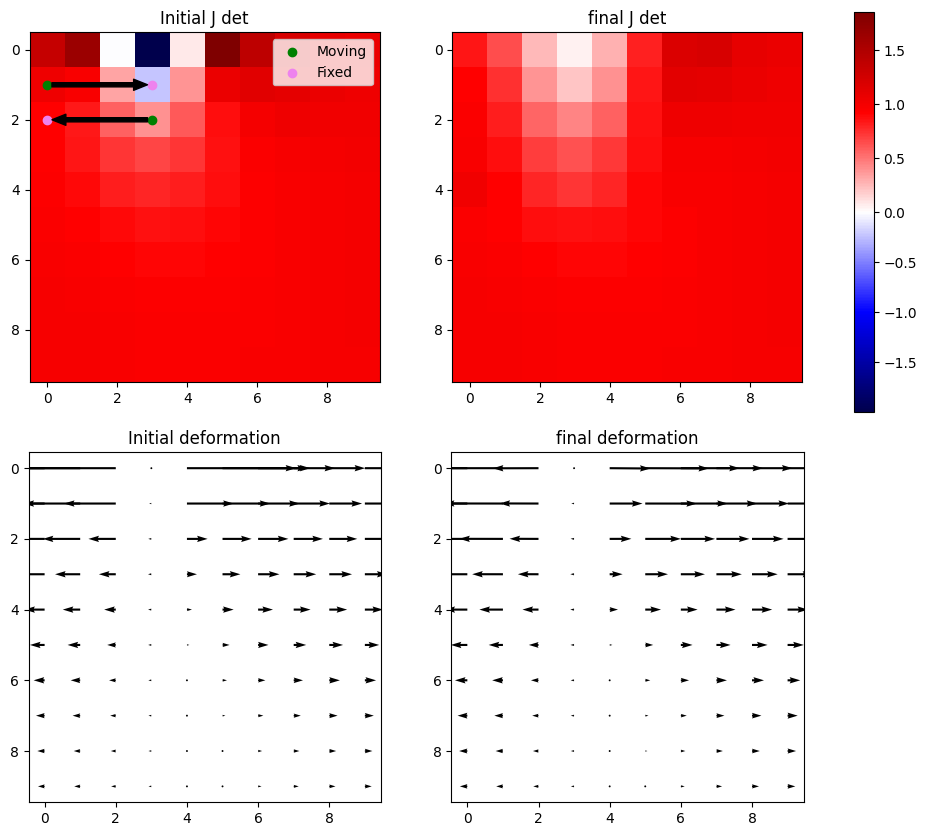

In [1134]:
# test gradient descent fjnjk

msample = np.array([
    [0, 1, 0],
    [0, 2, 3],
])
fsample = np.array([
    [0, 1, 3],
    [0, 2, 0],
])

fixed_sample = np.zeros((1, 10, 10)) # depth, rows, cols
#test_grad(fixed_sample, msample, fsample)
#test_scipy(fixed_sample, msample, fsample)
red_test_scipy(fixed_sample, msample, fsample)

# takes 15 mins and does not conclude on full 20x40 constraints
# 1.5mins on 10x10 constraints
# reduce constraints
# (10,5) - 50 vs 5 - 3.9s vs 0.15s
# (5,5) - 25 vs 5 - 0.35s vs 0.0645s
# (10, 10) - 100 vs 5 - 50s vs 0.46s
# (20, 20) - 400 vs 5 - waited for full one to run for 20min vs 1.5min

# 20x40 with 5 random constraints - 10.5 mins
# 20x40 run over the full thing - 174 min does not finish


Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
Negative Jacobians found at []
Total time taken for iterative SLSQP : 0.00019216537475585938 split as []
            x-def          y-def            jacobian          
              min  max       min       max       min       max
initial -0.999943  0.0 -1.006354 -0.992606  0.618473  1.092229
final   -0.999950  0.0 -1.002380 -0.995291  0.619830  1.091817
meshgrid shape for plot: (5, 5)


/var/folders/pj/ny1dgkl90cj0mpph_t0mvd000000gn/T/ipykernel_61428/1640093246.py:25: DeprecationWarning: scipy.sparse.linalg.lgmres called without specifying `atol`. The default value will change in the future. To preserve current behavior, set ``atol=tol``.
  phi_xy = lgmres(A_, b_, tol = 1e-2)[0]


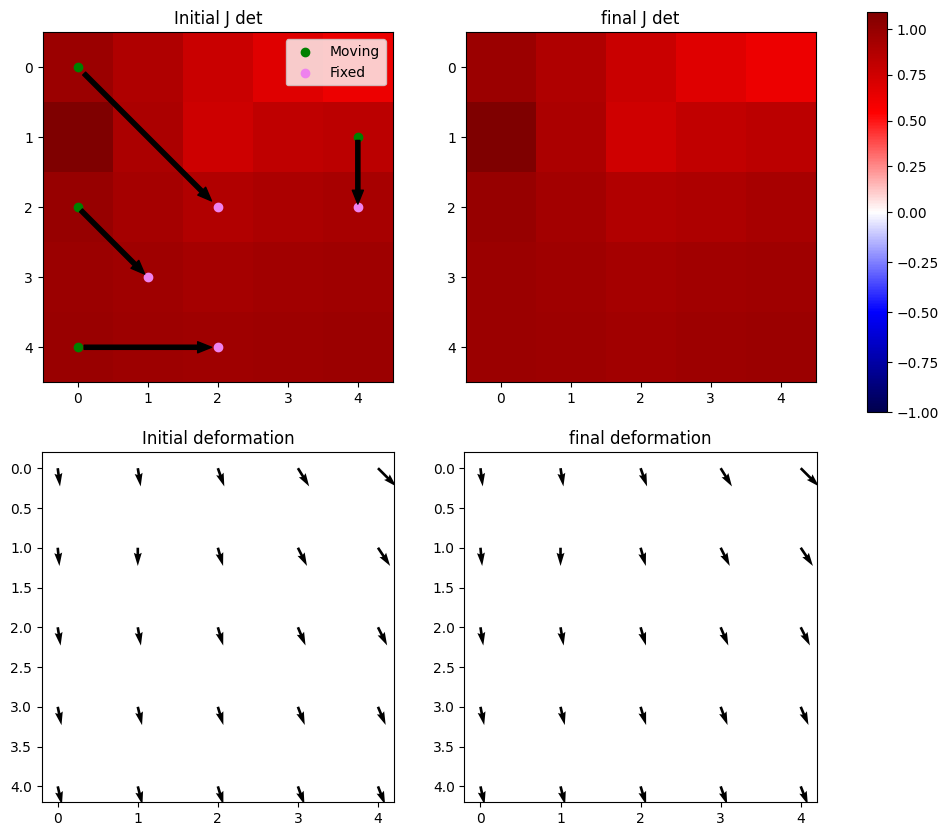

In [1135]:
msample = np.array([
    [0, 0, 0],
    [0, 2, 0],
    [0, 4, 0],
    [0, 1, 4],
])
fsample = np.array([
    [0, 2, 2],
    [0, 3, 1],
    [0, 4, 2],
    [0, 2, 4],
])

fixed_sample = np.zeros((1, 5, 5))
#test_grad(fixed_sample, msample, fsample)
#test_scipy(fixed_sample, msample, fsample)
red_test_scipy(fixed_sample, msample, fsample)

Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
Negative Jacobians found at [ 4 14]
Analysing index 4: Original coord: (4, 0, 0), nearest: (4, 2, 0)
nz ny nx 1 5 5
Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A


/var/folders/pj/ny1dgkl90cj0mpph_t0mvd000000gn/T/ipykernel_61428/1640093246.py:25: DeprecationWarning: scipy.sparse.linalg.lgmres called without specifying `atol`. The default value will change in the future. To preserve current behavior, set ``atol=tol``.
  phi_xy = lgmres(A_, b_, tol = 1e-2)[0]


Lapl eqns for index 4 solved in 0.10810184478759766s
Optimization terminated successfully    (Exit mode 0)
            Current function value: 12.359296659570356
            Iterations: 39
            Function evaluations: 2048
            Gradient evaluations: 39
Optimisation for index 4 completed in 0.2732110023498535s
OP result error for index 4: 12.359296659570356
RESULT SHAPES (10, 10) (5, 5) 2 7 0 5 2
Total time taken for iterative SLSQP : 0.38246607780456543 split as [0.2732110023498535]
            x-def               y-def            jacobian          
              min       max       min       max       min       max
initial -3.006613 -2.972020 -2.999864  2.999864 -0.802068  2.780505
final   -2.976345 -2.829967 -1.945113  1.659387  0.669853  1.674487
meshgrid shape for plot: (10, 10)


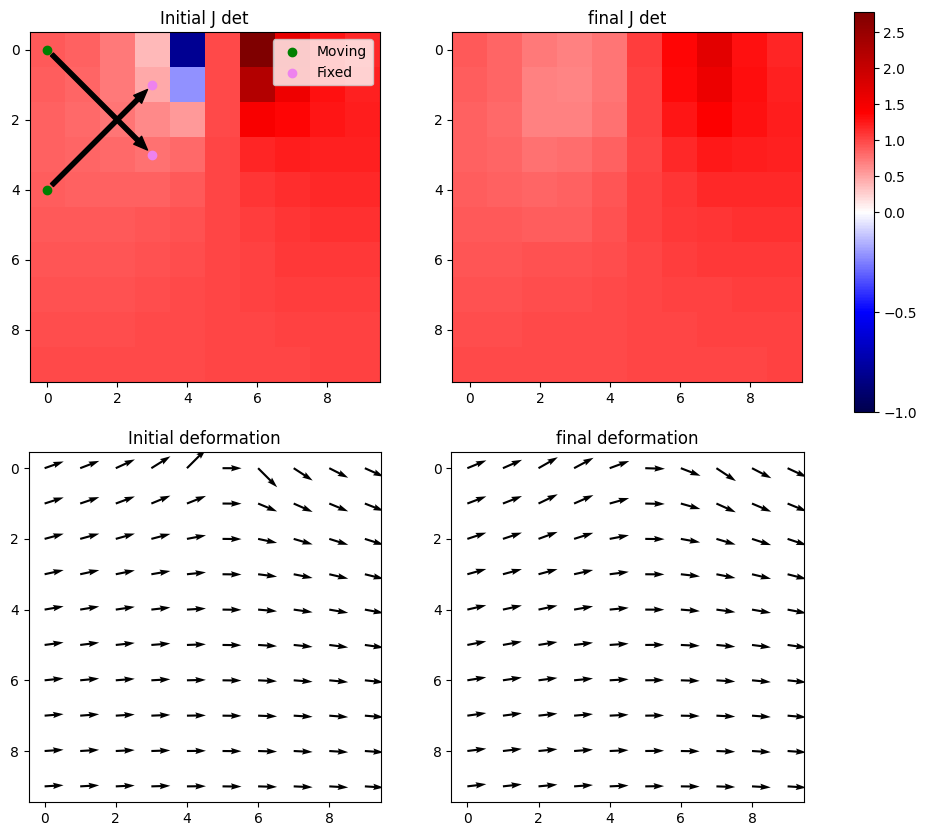

In [1136]:
msample = np.array([
    [0, 0, 0],
    [0, 4, 0],
])
fsample = np.array([
    [0, 3, 3],
    [0, 1, 3],
])

fixed_sample = np.zeros((1, 10, 10))
#test_grad(fixed_sample, msample, fsample)
#test_scipy(fixed_sample, msample, fsample)
red_test_scipy(fixed_sample, msample, fsample)

Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
Negative Jacobians found at [3 8 0]
Analysing index 3: Original coord: (3, 0, 0), nearest: (2, 2, 0)
nz ny nx 1 5 5
Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
Lapl eqns for index 3 solved in 0.07932424545288086s


/var/folders/pj/ny1dgkl90cj0mpph_t0mvd000000gn/T/ipykernel_61428/1640093246.py:25: DeprecationWarning: scipy.sparse.linalg.lgmres called without specifying `atol`. The default value will change in the future. To preserve current behavior, set ``atol=tol``.
  phi_xy = lgmres(A_, b_, tol = 1e-2)[0]


Optimization terminated successfully    (Exit mode 0)
            Current function value: 9.839429598295773
            Iterations: 35
            Function evaluations: 1842
            Gradient evaluations: 35
Optimisation for index 3 completed in 0.20498371124267578s
OP result error for index 3: 9.839429598295773
RESULT SHAPES (5, 5) (5, 5) 0 5 0 5 2
Total time taken for iterative SLSQP : 0.28482604026794434 split as [0.20498371124267578]
            x-def               y-def            jacobian          
              min       max       min       max       min       max
initial  0.000000  0.000000 -2.999750  2.999750 -0.645503  2.016266
final   -0.000092  0.000194 -1.608251  2.043597  0.485187  1.279635
meshgrid shape for plot: (5, 5)


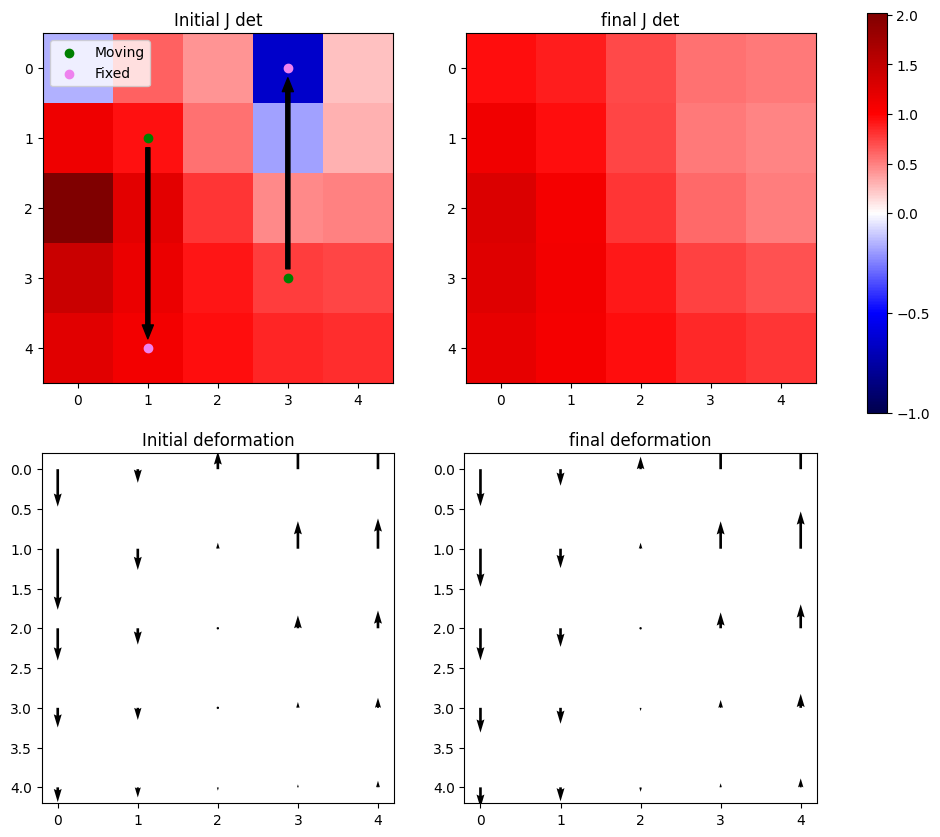

In [1137]:
msample = np.array([
    [0, 1, 1],
    [0, 3, 3],
])
fsample = np.array([
    [0, 4, 1],
    [0, 0, 3],
])

fixed_sample = np.zeros((1, 5, 5))
#test_grad(fixed_sample, msample, fsample)
#test_scipy(fixed_sample, msample, fsample)
red_test_scipy(fixed_sample, msample, fsample)

Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
Reached the optimisation line. Number of constraints = 100


/var/folders/pj/ny1dgkl90cj0mpph_t0mvd000000gn/T/ipykernel_61428/3244334675.py:55: DeprecationWarning: scipy.sparse.linalg.lgmres called without specifying `atol`. The default value will change in the future. To preserve current behavior, set ``atol=tol``.
  phi_xy = lgmres(A_, b_, tol = 1e-2)[0]


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.03754981279269963
            Iterations: 196
            Function evaluations: 39665
            Gradient evaluations: 196
Optimisation completed! Time taken = 23.516836881637573s
OP phi0 error: 0.0016310465134333461
OP result error: 0.03754981279269963
OP deviation from initial: 10.28867273510279
            x-def               y-def            jacobian          
              min       max       min       max       min       max
initial -3.999655 -0.999914  0.000000  0.000000 -0.217001  1.428312
final   -3.940850 -1.059123 -1.285116  0.005078  0.121512  1.313229
meshgrid shape for plot: (10, 10)
Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
Negative Jacobians found at [5 6]
Analysing index 5: Original coord: (5, 0, 0), nearest: (5, 2, 0)
nz ny nx 1 5 5
Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A


/var/folders/pj/ny1dgkl90cj0mpph_t0mvd000000gn/T/ipykernel_61428/1640093246.py:25: DeprecationWarning: scipy.sparse.linalg.lgmres called without specifying `atol`. The default value will change in the future. To preserve current behavior, set ``atol=tol``.
  phi_xy = lgmres(A_, b_, tol = 1e-2)[0]


Lapl eqns for index 5 solved in 0.09408783912658691s
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.0042007361936545
            Iterations: 33
            Function evaluations: 1736
            Gradient evaluations: 33
Optimisation for index 5 completed in 0.2570149898529053s
OP result error for index 5: 4.0042007361936545
RESULT SHAPES (10, 10) (5, 5) 3 8 0 5 2
Total time taken for iterative SLSQP : 0.3579578399658203 split as [0.2570149898529053]
            x-def               y-def            jacobian          
              min       max       min       max       min       max
initial -3.999655 -0.999914  0.000000  0.000000 -0.217001  1.428312
final   -3.171853 -1.730797 -0.000169  0.000265  0.489092  1.104855
meshgrid shape for plot: (10, 10)


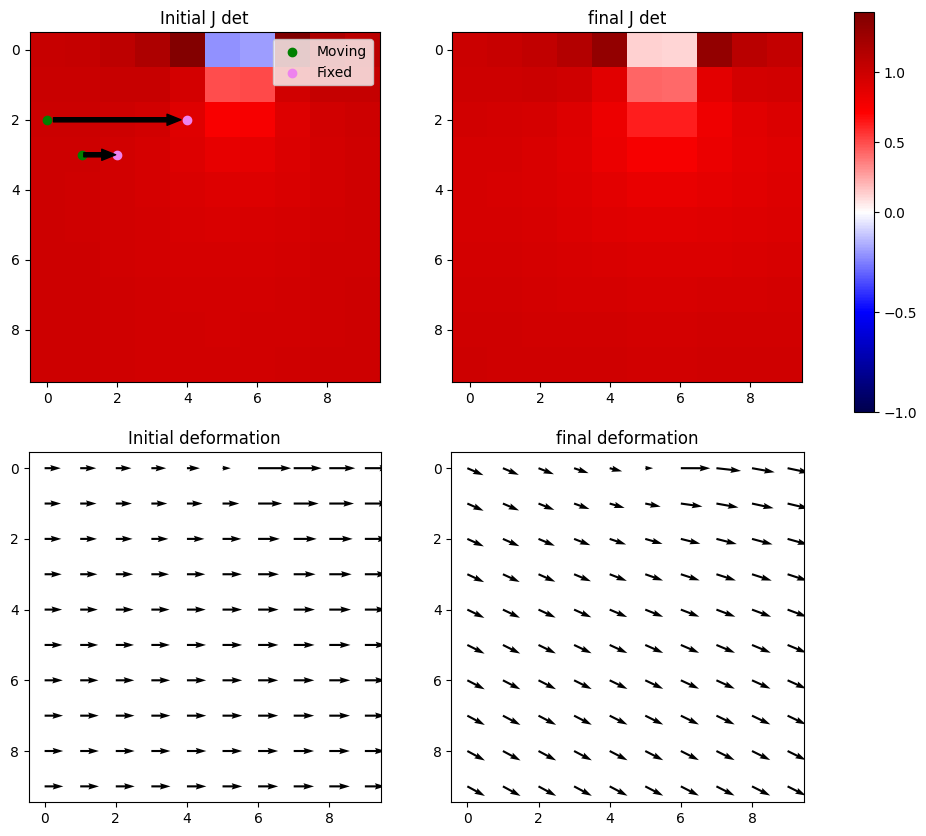

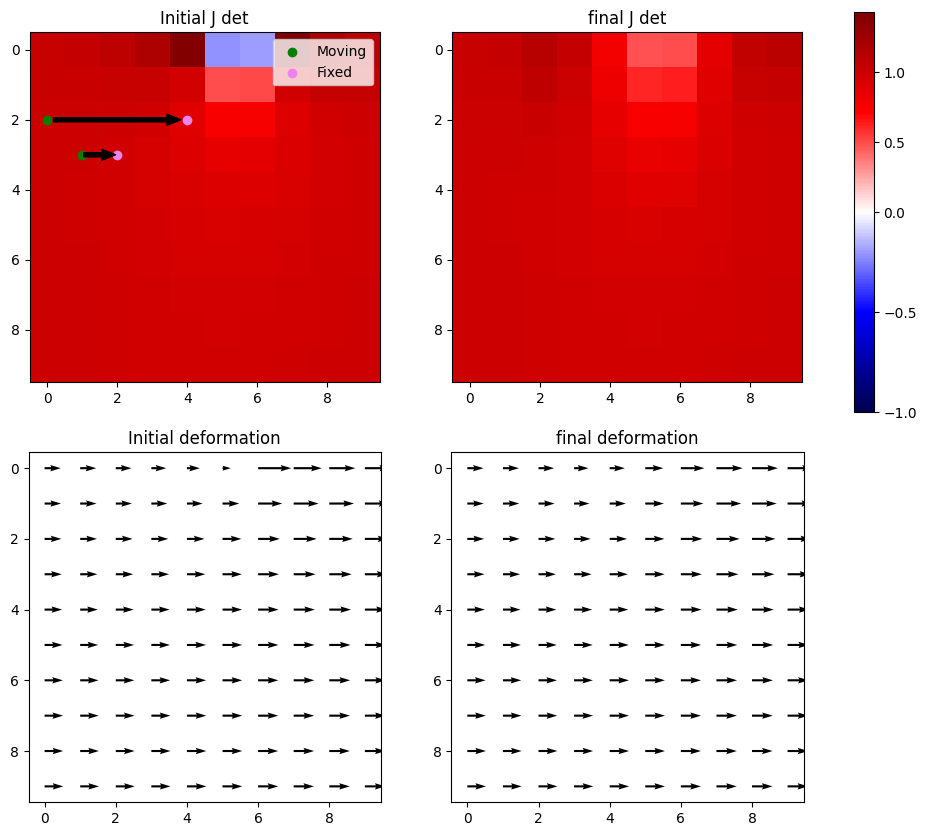

In [1138]:
msample = np.array([
    [0, 2, 0],
    [0, 3, 1],
])
fsample = np.array([
    [0, 2, 4],
    [0, 3, 2],
])

fixed_sample = np.zeros((1, 10, 10))
#test_grad(fixed_sample, msample, fsample)
test_scipy(fixed_sample, msample, fsample)
red_test_scipy(fixed_sample, msample, fsample)

In [1139]:
# # # plot graphs of errors
# # init_GD = [0.039, 0.048, 0.039, 0.011]
# # final_GD = [12.9, 3.39, 2.162, 4.282]
# # dev_GD = [9.46, 2.27, 1.181, 2.497]

# # init_OP = [0.0015, 0.0033, 0.0015, 0.0001]
# # final_OP = [5.32, 0.235, 0.0289, 0.497]
# # dev_OP = [18.57, 3.315, 1.2811, 1.144]

# indices = range(len(init_GD))

# fig, ax = plt.subplots(1, 2, figsize=(15,5))

# ax[0].set_title('Error of final phi')
# ax[1].set_title('Deviation from phi_prime')
# ax[0].plot(indices, init_GD, label='init phi err', marker='.')
# ax[0].plot(indices, final_GD, label='GD final err', marker='.')
# ax[1].plot(indices, dev_GD, label='GD', marker='.')

# ax[0].plot(indices, init_OP, label='init_phi_err_OP', marker='.')
# ax[0].plot(indices, final_OP, label='cobyla fin err', marker='.')
# ax[1].plot(indices, dev_OP, label='cobyla', marker='.')

# for i in range(2):
#     ax[i].set_xticks(indices)
#     ax[i].legend()


### Test with actual data - corrections needed

In [1140]:
# data analysis

# Create sample set of points
mpoints_path = "data/corrected_correspondences_count_touching/mpoints.npy"
fpoints_path = "data/corrected_correspondences_count_touching/fpoints.npy"

In [1141]:
mpoints, fpoints = correspondences.downsample_points(mpoints_path, fpoints_path, debug=False)
print(mpoints.shape, fpoints.shape)

for i in [0,1,2]:
    print(np.max(mpoints[i]), np.min(mpoints[i]), np.max(fpoints[i]), np.min(fpoints[i]))

#print(fpoints)

FileNotFoundError: [Errno 2] No such file or directory: 'data/corrected_correspondences_count_touching/mpoints.npy'

Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
(15, 3) (15, 3)
Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A


/var/folders/pj/ny1dgkl90cj0mpph_t0mvd000000gn/T/ipykernel_61428/1640093246.py:43: DeprecationWarning: scipy.sparse.linalg.lgmres called without specifying `atol`. The default value will change in the future. To preserve current behavior, set ``atol=tol``.
  phi_xy = lgmres(A_, b_, tol = 1e-2)[0]


Negative Jacobians found at [ 17  18  57  58  19  98  97  59  99  16 138]
Analysing index 17: Original coord: (17, 0, 0), nearest: (17, 2, 0)
nz ny nx 1 5 5
Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
Lapl eqns for index 17 solved in 0.12539315223693848s
Optimization terminated successfully    (Exit mode 0)
            Current function value: 187.3388907232158
            Iterations: 52
            Function evaluations: 2704
            Gradient evaluations: 52
Optimisation for index 17 completed in 0.3363521099090576s
OP result error for index 17: 187.3388907232158
RESULT SHAPES (20, 40) (5, 5) 15 20 0 5 2
Analysing index 59: Original coord: (19, 1, 0), nearest: (19, 2, 0)
nz ny nx 1 5 5
Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
Lapl eqns for index 59 solved in 0.07135391235351562s
Optimization terminated successfully    (Exit mode 0)
            Current function value: 90.70720212415831
            Iterations: 55

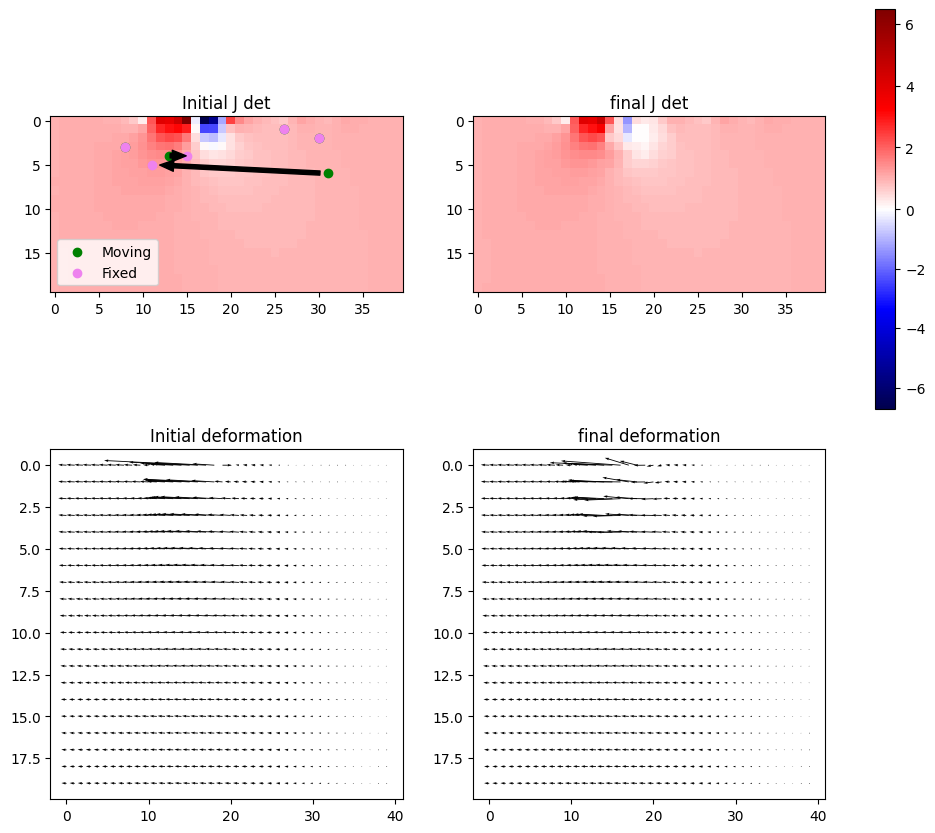

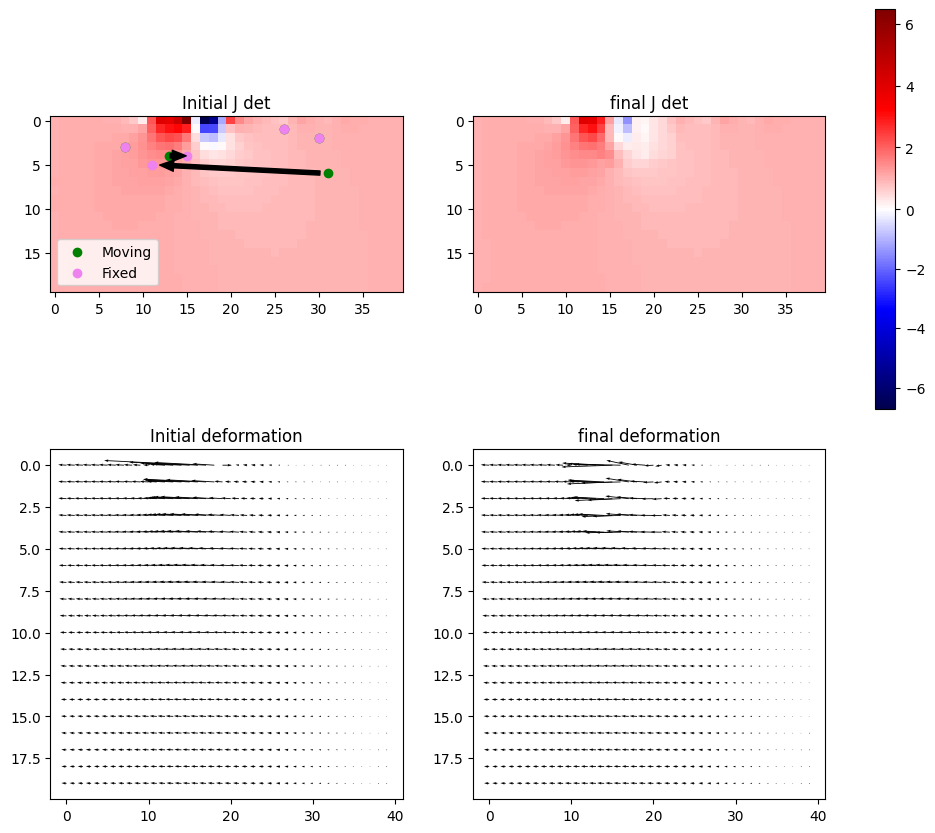

In [ ]:
fixed_sample = np.zeros((1, 20, 40))

deformation_i, A, Zd, Yd, Xd = laplacian.sliceToSlice3DLaplacian(fixed_sample, mpoints, fpoints)

# z values in mpoints, fpoints are for 3 slices numbered 0,1,2
slice_no = 1

# use 
mask = mpoints[:,0]==slice_no
new_mpoints = mpoints[mask].copy()
new_mpoints[:,0] = 0

mask = fpoints[:,0]==slice_no
new_fpoints = fpoints[mask].copy()
new_fpoints[:,0] = 0

print(new_mpoints.shape, new_fpoints.shape)


#test_grad(fixed_sample, msample, fsample)
red_test_scipy2(fixed_sample, new_mpoints[:5], new_fpoints[:5])

### Treating correspondences as soft constraints

In [ ]:
# compute deformation, find negative Jacobian points, find nearest correspondence, remove it and recompute
# what is the guarantee that the nearest correspondence is the problematic one? 
# to find the problematic one we end up arriving at Andy's approach
